In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
import random
random.seed(0)
import numpy as np
np.random.seed(0)
from sklearn.model_selection import train_test_split,StratifiedKFold
import itertools
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
torch.manual_seed(0)
import torch.nn as nn
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.phrases import Phrases, Phraser
nltk.download('punkt')
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from torch.optim import AdamW, SGD, Adam

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%%capture
!pip install torchtext

In [ ]:
import torchtext
from torchtext import data
from torchtext.data import get_tokenizer #https://stackoverflow.com/questions/42711144/how-can-i-install-torchtext

<h1>Load our data</h1>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df_train_set = pd.read_csv('/content/drive/My Drive/mathimata_sxolhs/XEIMERINO_EKSAMHNO_2/TEXNHTH_NOHMOSYNH_2/Ergasia 4/train_set.csv')
df_test_set = pd.read_csv('/content/drive/My Drive/mathimata_sxolhs/XEIMERINO_EKSAMHNO_2/TEXNHTH_NOHMOSYNH_2/Ergasia 4/test_set.csv')
df_valid_set = pd.read_csv('/content/drive/My Drive/mathimata_sxolhs/XEIMERINO_EKSAMHNO_2/TEXNHTH_NOHMOSYNH_2/Ergasia 4/valid_set.csv')

<h1>We print our data and check for null values</h1><br>

We can observe from the output of the **info** method that there are no null values

In [ ]:
print(df_train_set.head(),'\n')
print(df_train_set.info(), '\n')

print(df_valid_set.head(),'\n')
print(df_valid_set.info(), '\n')

print(df_test_set.head(),'\n')
print(df_test_set.info(), '\n')

   New_ID                                               Text Sentiment   Party
0   35027  #απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...   NEUTRAL  SYRIZA
1    9531  Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...  NEGATIVE      ND
2   14146  Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...  POSITIVE     KKE
3   28716  @five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...   NEUTRAL     KKE
4   32886  @ai_katerina Αυτό που είναι συγκλονιστικό είνα...   NEUTRAL  SYRIZA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36630 entries, 0 to 36629
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   New_ID     36630 non-null  int64 
 1   Text       36630 non-null  object
 2   Sentiment  36630 non-null  object
 3   Party      36630 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB
None 

   New_ID                                               Text Sentiment   Party
0     435  @GLinard @teza_tereza @AdonisGeorgi

<h1>Barplots that illustrate the number of tweets and their sentiment for each party</h1>

In [ ]:
group_df_by_sentiment_party_train = df_train_set.groupby(['Sentiment', 'Party']).size().reset_index(name='NumOfTweets')
group_df_by_sentiment_party_valid = df_valid_set.groupby(['Sentiment', 'Party']).size().reset_index(name='NumOfTweets')

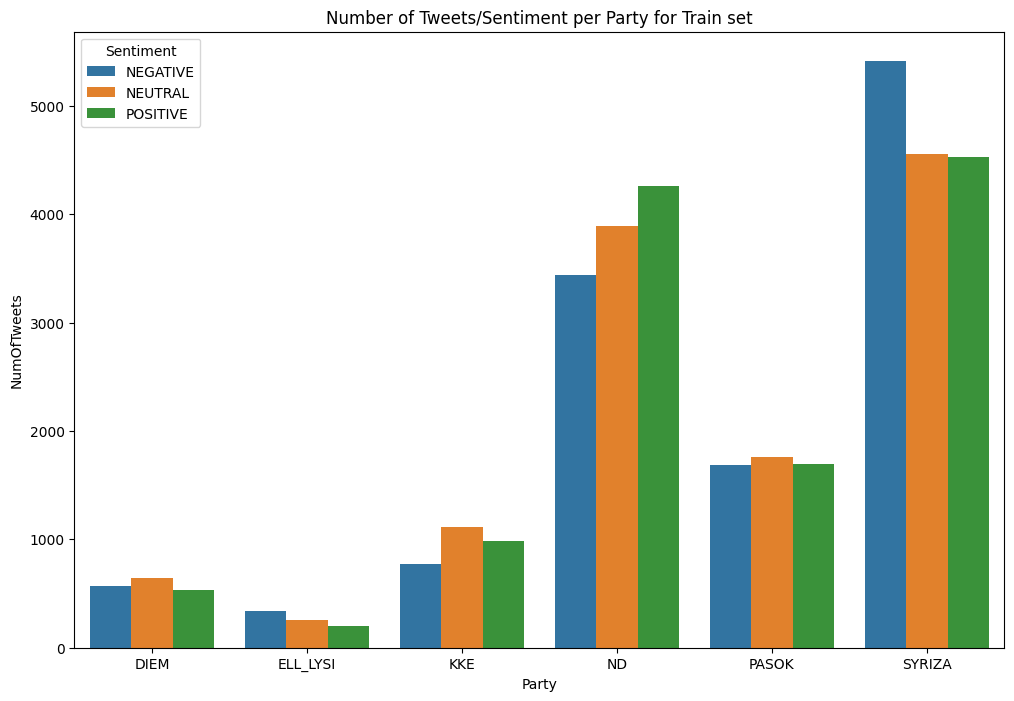

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x='Party', y='NumOfTweets', hue='Sentiment', data=group_df_by_sentiment_party_train)
plt.title('Number of Tweets/Sentiment per Party for Train set')
plt.show()

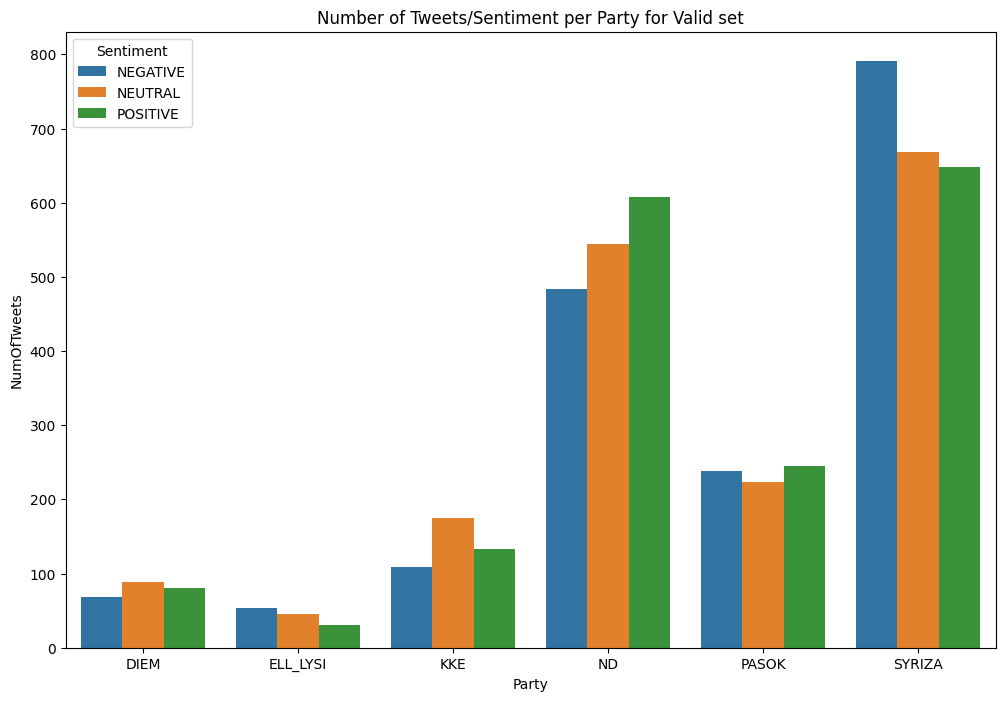

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x='Party', y='NumOfTweets', hue='Sentiment', data=group_df_by_sentiment_party_valid)
plt.title('Number of Tweets/Sentiment per Party for Valid set')
plt.show()

<h1>Plot the number of tweets for each party</h1>

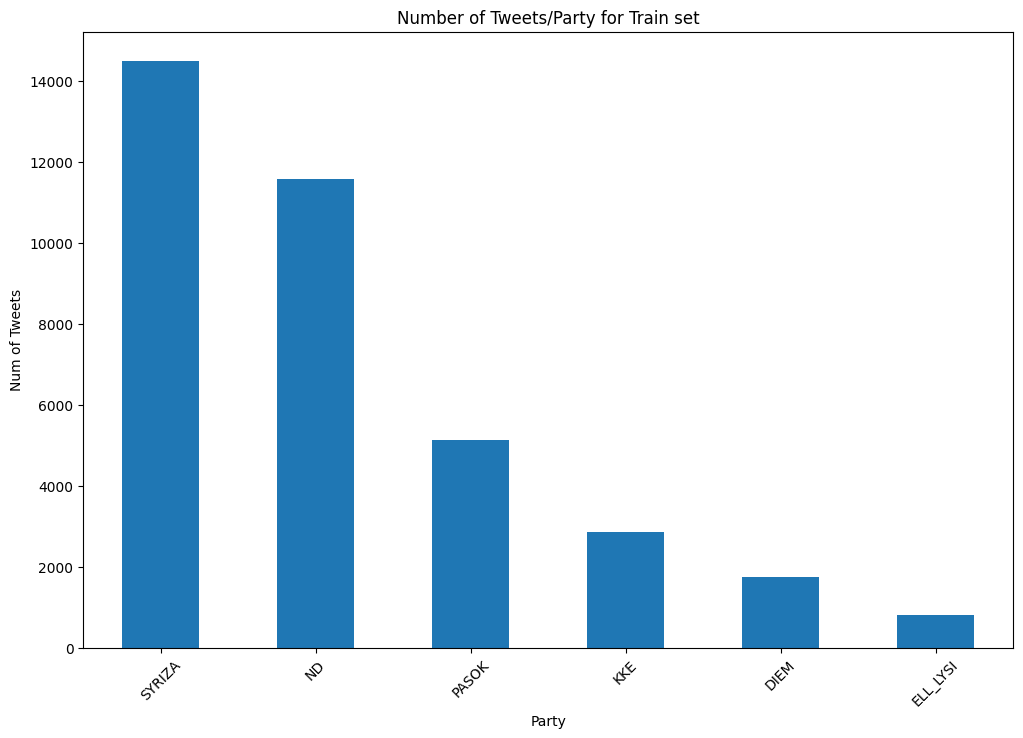

In [ ]:
df_train_set['Party'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Number of Tweets/Party for Train set')
plt.ylabel('Num of Tweets')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

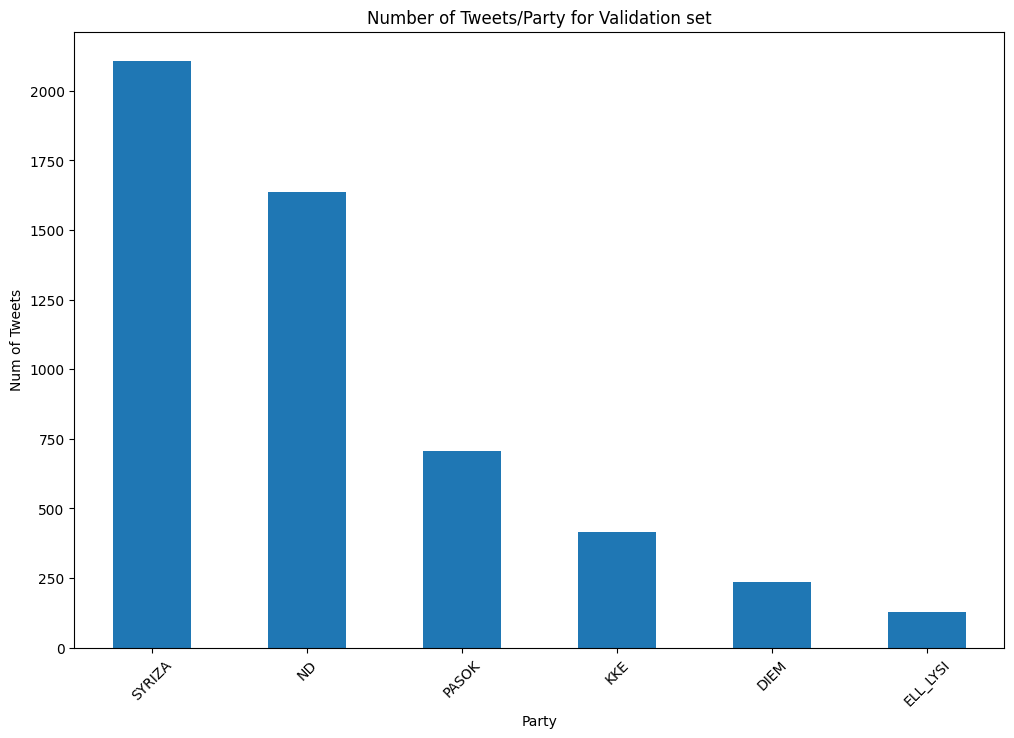

In [ ]:
df_valid_set['Party'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Number of Tweets/Party for Validation set')
plt.ylabel('Num of Tweets')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

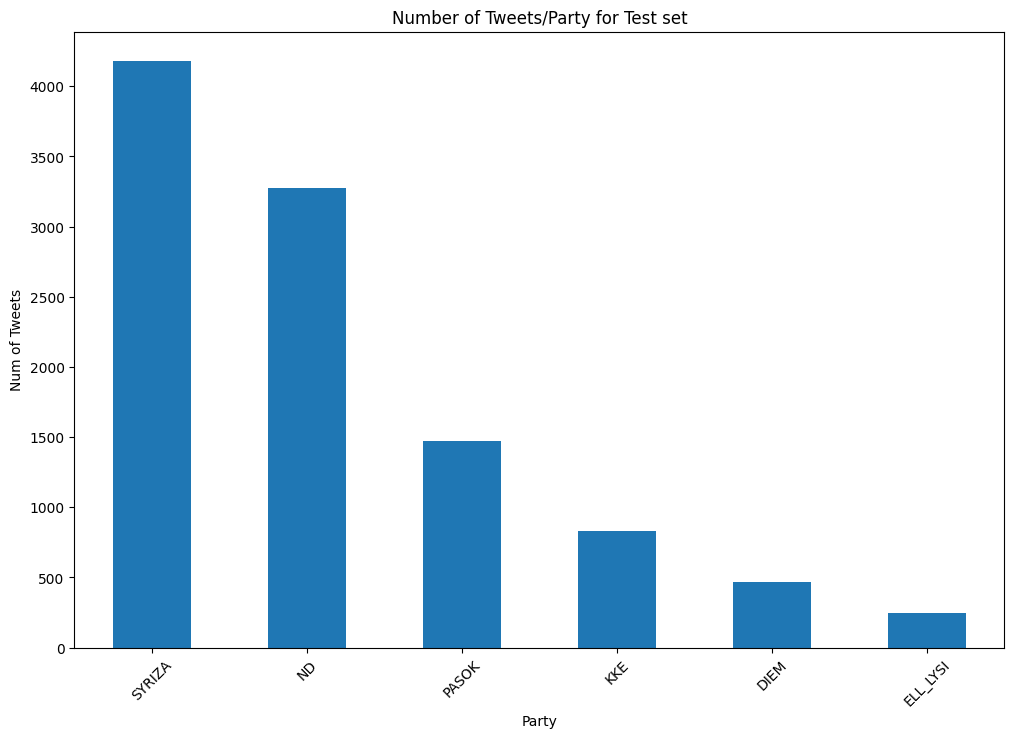

In [ ]:
df_test_set['Party'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Number of Tweets/Party for Test set')
plt.ylabel('Num of Tweets')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

<h1>Data preprocessing</h1>
<h4>Turn the categorical values to numerical</h4>

In [ ]:
df_train_set['Sentiment'].head()

0     NEUTRAL
1    NEGATIVE
2    POSITIVE
3     NEUTRAL
4     NEUTRAL
Name: Sentiment, dtype: object

In [ ]:
le = LabelEncoder()

df_train_set['Sentiment'] = le.fit_transform(df_train_set['Sentiment'])
df_valid_set['Sentiment'] = le.fit_transform(df_valid_set['Sentiment'])
print(df_train_set['Sentiment'].head())
print(df_valid_set['Sentiment'].head())

0    1
1    0
2    2
3    1
4    1
Name: Sentiment, dtype: int64
0    2
1    0
2    0
3    2
4    1
Name: Sentiment, dtype: int64


<h4>Function that turn the text of each tweet to lowercase, removes stopwords and special charachters, urls, mentions e.t.c</h4>

In [ ]:
# NOTE: To remove the stopwords I downloaded locally the stopwords-el.json file from the repository
# at https://github.com/stopwords-iso/stopwords-el and uploaded it
# to my notebook at gree-stopwords-json-file.

# Load Greek stopwords from the JSON file
with open('/content/drive/My Drive/mathimata_sxolhs/XEIMERINO_EKSAMHNO_2/TEXNHTH_NOHMOSYNH_2/Ergasia 4/stopwords_el_2.json', 'r', encoding='utf-8') as file:
    greek_stopwords = json.load(file)

def preprocess_tweet(tweet):
    tweet = tweet.lower().replace('_', ' ')

    # delete mentions
    tweet = re.sub(r'@\w+', '', tweet)

    # delete urls
    tweet = re.sub(r'http\S+', '', tweet)

    # delete special characters but keep the alphanumeric ones, including all Greek letters
    #tweet = re.sub(r'[^αβγδεζηθικλμνξοπρστυφχψωςάέίόώύήΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩa-zA-Z0-9\s]', '', tweet)

    # I keep only greek charachters (I used to keep and english, I am trying it this way to see if I
    # will achieve higher f1 score)
    tweet = re.sub(r'[^αβγδεζηθικλμνξοπρστυφχψωςάέίόώύήΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ0-9\s]', '', tweet)

    # delete Greek stopwords
    tweet_words = tweet.split()
    cleaned_words = [word for word in tweet_words if word not in greek_stopwords]
    tweet = ' '.join(cleaned_words)

    tweet = tweet.strip()

    return tweet

In [ ]:
df_train_set['Text'] = df_train_set['Text'].apply(preprocess_tweet)
df_test_set['Text'] = df_test_set['Text'].apply(preprocess_tweet)
df_valid_set['Text'] = df_valid_set['Text'].apply(preprocess_tweet)

In [ ]:
print(df_train_set['Text'].head(), '\n')
print(df_test_set['Text'].head(), '\n')
print(df_valid_set['Text'].head(), '\n')

0    απολυμανση κοριοι απεντομωση κοριος απολυμανσε...
1    έξι νέες επιστολές μακεδονία καίνε νδ μητσοτάκ...
2     ισχυρό κκε δύναμη λαού βουλή καθημερινούς αγώνες
3             μνημονιακότατο μερα25 εκλογες 2019 8 κκε
4                     συγκλονιστικό ψυχασθένεια τσίπρα
Name: Text, dtype: object 

0    κυριάκος μητσοτάκης ξέρει μουσείο βεργίνας μέσ...
1    συνέντευξη υποψήφιας βουλευτή νέα δημοκρατία β...
2    εκλογές μαθητές φοιτητές ψηφίζουμε ίδιο τρόπο ...
3    γεννηματά κιναλ γίνει δεκανίκι κανενός ενδιαφέ...
4    κυριακή εκλογών οκτώβρης 1993 ξημερώματα δευτέ...
Name: Text, dtype: object 

0    θελεις μιλησεις βοσκοτοπια αιγιαλους παραγραφέ...
1    τσίπρας ζητήσαμε αντιπολίτευση συμμετέχει διαδ...
2    σωστος ελληνας δημοκρατης ελληνας εξωτερικου ε...
3    βλέπεις ενδιαφέρουν μητσοτακηδες γιατί πήγε κό...
4    συνέντευξη μητσοτάκη αίρεση 13η σύνταξη αύξηση...
Name: Text, dtype: object 



**We load the spacy model to perform lemmatization tokenaziation for greek words** <br>
Sometimes it's necessary to restart the kernel in order for the following to work

<h1>ATTENTION:</h1><h2>The following command needs to be executed only one time. If an error occurs from the following spacy.load() command just restart the kernel and run all the commands except this one.</h2>

In [ ]:
%%capture
# This needs to be executed only one time. If an error occurs from the following spacy.load() command
# just restart the kernel and run all the commands except this one.
!pip install -U spacy

In [ ]:
nlp = spacy.load('/content/drive/My Drive/mathimata_sxolhs/XEIMERINO_EKSAMHNO_2/TEXNHTH_NOHMOSYNH_2/Ergasia 4/el_core_news_lg_3/el_core_news_lg-3.7.0')

<h1>LEMMATIZATION - TOKENIZATION</h1>

In [ ]:
# For the lemmatization tokenazation step, I downloaded locally the el_core_news_lg model,
# then I zipped it and I uploaded it as a public dataset.
def lemmatize_tokenize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])


df_train_set['Text'] = df_train_set['Text'].apply(lemmatize_tokenize_text)
df_test_set['Text'] = df_test_set['Text'].apply(lemmatize_tokenize_text)
df_valid_set['Text'] = df_valid_set['Text'].apply(lemmatize_tokenize_text)

In [ ]:
print(df_train_set['Text'].head(), '\n')
print(df_test_set['Text'].head(), '\n')
print(df_valid_set['Text'].head(), '\n')

0    απολυμανση κοριοι απεντομωση κοριος απολυμανσε...
1    έξι νέος επιστολή μακεδονία καίνε νδ μητσοτάκη...
2     ισχυρός κκε δύναμη λαός βουλή καθημερινός αγώνας
3             μνημονιακότατο μερα25 εκλογες 2019 8 κκε
4                   συγκλονιστικός ψυχασθένεια τσίπρας
Name: Text, dtype: object 

0    κυριάκος μητσοτάκης ξέρω μουσείο βεργίνας μέσω...
1    συνέντευξη υποψήφιος βουλευτής νέος δημοκρατία...
2    εκλογή μαθητής φοιτητής ψηφίζω ίδιος τρόπος αγ...
3    γεννηματά κιναλ γίνομαι δεκανίκι κανενός ενδια...
4    κυριακός εκλογή οκτώβρης 1993 ξημερώματα δευτέ...
Name: Text, dtype: object 

0    θελεις μιλησεις βοσκοτοπια αιγιαλος παραγραφή ...
1    τσίπρας ζητήζω αντιπολίτευση συμμετέχω διαδικα...
2    σωστος ελληνας δημοκρατης ελληνας εξωτερικου ε...
3    βλέπεις ενδιαφέρω μητσοτακηδας γιατί πήγε κότε...
4    συνέντευξη μητσοτάκης αίρεση 13ος σύνταξη αύξη...
Name: Text, dtype: object 



<h1> Number of Unique words - Wordcloud</h1>

In [ ]:
def unique_words_num(tweets):
    # Function that counts the number of the unique words from the Text column of each dataframe
    words = set()
    for tweet in tweets:
        words.update(tweet.split())
    return len(words)

In [ ]:
print("Num of unique words in df_train_set:", unique_words_num(df_train_set['Text']))
print("Num of unique words in df_test_set:", unique_words_num(df_test_set['Text']))
print("Num of unique words in df_valid_set:", unique_words_num(df_valid_set['Text']))

Num of unique words in df_train_set: 58402
Num of unique words in df_test_set: 26281
Num of unique words in df_valid_set: 16629


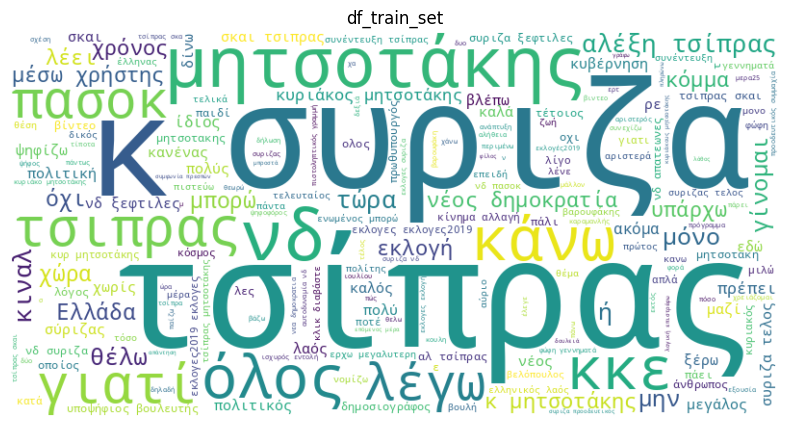

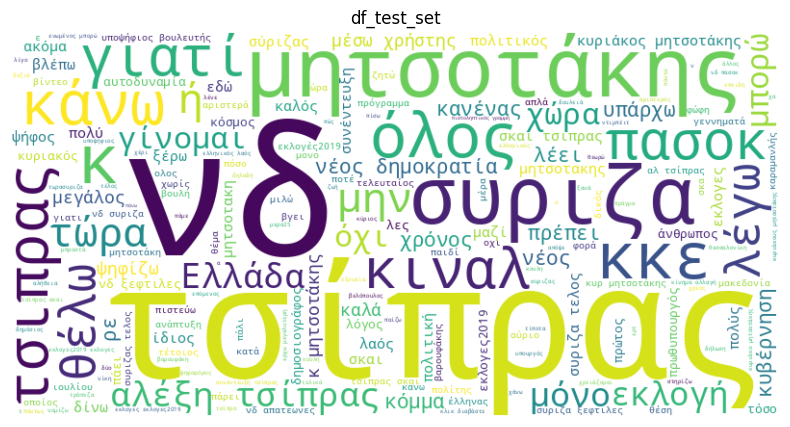

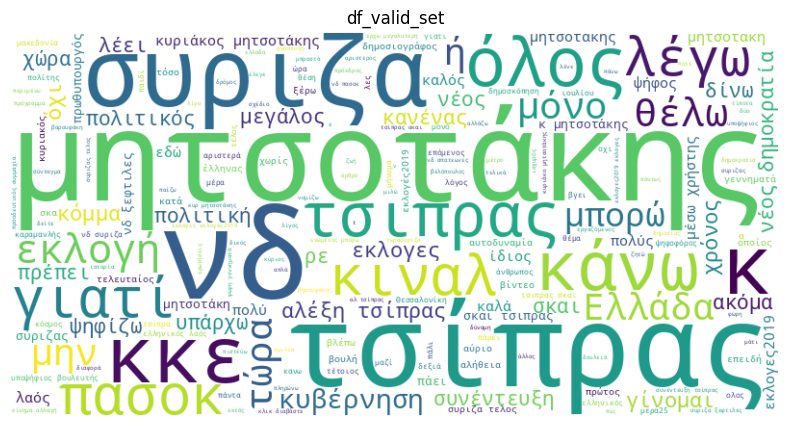

In [ ]:
def plot_wordcloud(tweets, title):
    tweets_joined = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(tweets_joined)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word cloud for each dataframe
plot_wordcloud(df_train_set['Text'], 'df_train_set')
plot_wordcloud(df_test_set['Text'], 'df_test_set')
plot_wordcloud(df_valid_set['Text'], 'df_valid_set')

<h1> Load pre-trained models </h1>

In [ ]:
# https://stackoverflow.com/questions/69907682/what-are-differences-between-automodelforsequenceclassification-vs-automodel

# GreekBERT
model_name_greekbert = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer_greekbert = AutoTokenizer.from_pretrained(model_name_greekbert)
model_greekbert = AutoModelForSequenceClassification.from_pretrained(model_name_greekbert, num_labels=3)

# DistilGREEK-BERT
model_name_distilgreekbert = "EftychiaKarav/DistilGREEK-BERT"
tokenizer_distilgreekbert = AutoTokenizer.from_pretrained(model_name_distilgreekbert)
model_distilgreekbert = AutoModelForSequenceClassification.from_pretrained(model_name_distilgreekbert, num_labels=3)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at EftychiaKarav/DistilGREEK-BERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class GreekElectionsDataset(Dataset):
    def __init__(self, texts=None, labels=None, tokenizer=None, max_token_len=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True,
        )


        if self.labels is not None:
            label = self.labels[item]
            return {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
            }


<h1> Create dataloaders </h1>

In [ ]:
# Dataframes -> GreekEleactionsDataset instances
train_dataset = GreekElectionsDataset(df_train_set['Text'], df_train_set['Sentiment'], tokenizer_greekbert, max_token_len=128)
valid_dataset = GreekElectionsDataset(df_valid_set['Text'], df_valid_set['Sentiment'], tokenizer_greekbert, max_token_len=128)
test_dataset = GreekElectionsDataset(df_test_set['Text'], tokenizer_greekbert, max_token_len=128)

batch_size = 32


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:

def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    predictions = []
    prediction_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.tolist())
            prediction_labels.extend(labels.tolist())

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    precision = precision_score(prediction_labels, predictions, average='weighted')
    recall = recall_score(prediction_labels, predictions, average='weighted')
    f1 = f1_score(prediction_labels, predictions, average='weighted')

    return accuracy, np.mean(losses), precision, recall, f1



In [ ]:
def train(epochs, model, train_dataloader, valid_dataloader, optimizer, device):
    # Initialize lists to store metrics for each epoch
    train_f1, valid_f1 = [], []
    train_precision, valid_precision = [], []
    train_recall, valid_recall = [], []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        # TRAINING PHASE
        train_acc, _ = train_epoch(model, train_dataloader, optimizer, device)

        # EVALUATION PHASE for training set
        train_acc, _, train_prec, train_rec, train_f1_score = eval_model(model, train_dataloader, device)
        train_f1.append(train_f1_score)
        train_precision.append(train_prec)
        train_recall.append(train_rec)

        # EVALUATION PHASE for validation set
        val_acc, _, val_prec, val_rec, val_f1_score = eval_model(model_greekbert, valid_dataloader, device)
        valid_f1.append(val_f1_score)
        valid_precision.append(val_prec)
        valid_recall.append(val_rec)

        print(f'Train accuracy {train_acc} Validation accuracy {val_acc}')
        print(f'Train F1: {train_f1_score:.2f}, Valid F1: {val_f1_score:.2f}, '
            f'Train Precision: {train_prec:.2f}, Valid Precision: {val_prec:.2f}, '
            f'Train Recall: {train_rec:.2f}, Valid Recall: {val_rec:.2f}')

        print(valid_f1)
    print(f'\nMEAN TRAIN F1 SCORE: {np.mean(train_f1):.4f}\n'
        f'MEAN VALIDATION F1 SCORE: {np.mean(valid_f1):.4f}\n'
        f'MEAN TRAIN PRECISION: {np.mean(train_precision):.4f}\n'
        f'MEAN VALIDATION PRECISION: {np.mean(valid_precision):.4f}\n'
        f'MEAN TRAIN RECALL: {np.mean(train_recall):.4f}\n'
        f'MEAN VALIDATION RECALL: {np.mean(valid_recall):.4f}\n')
    print(valid_f1)

    return model, train_acc, val_acc, train_f1_score, val_f1_score, train_prec, val_prec, train_rec, val_rec


In [ ]:
def plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs):
    epochs = epochs
    y = np.arange(epochs)
    height = 0.35

    plt.figure(figsize=(18, 6))


    plt.subplot(1, 3, 1)
    bars1 = plt.barh(y - height/2, train_f1, height, label='Train F1 Score')
    bars2 = plt.barh(y + height/2, valid_f1, height, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.ylabel('Epochs')
    plt.yticks(y)
    plt.xlabel('F1 Score')
    plt.legend()


    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', ha='left', va='center')


    plt.subplot(1, 3, 2)
    bars1 = plt.barh(y - height/2, train_precision, height, label='Train Precision Score')
    bars2 = plt.barh(y + height/2, valid_precision, height, label='Validation Precision Score')
    plt.title('Training and Validation Precision Scores')
    plt.ylabel('Epochs')
    plt.yticks(y)
    plt.xlabel('Precision Score')
    plt.legend()


    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', ha='left', va='center')


    plt.subplot(1, 3, 3)
    bars1 = plt.barh(y - height/2, train_recall, height, label='Train Recall Score')
    bars2 = plt.barh(y + height/2, valid_recall, height, label='Validation Recall Score')
    plt.title('Training and Validation Recall Score')
    plt.ylabel('Epochs')
    plt.yticks(y)
    plt.xlabel('Recall Score')
    plt.legend()


    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

<h1>bert-base-greek-uncased-v1</h1>

<h1>Learning rate experiments</h1>


------ LEARNING RATE = 0.1 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Reca

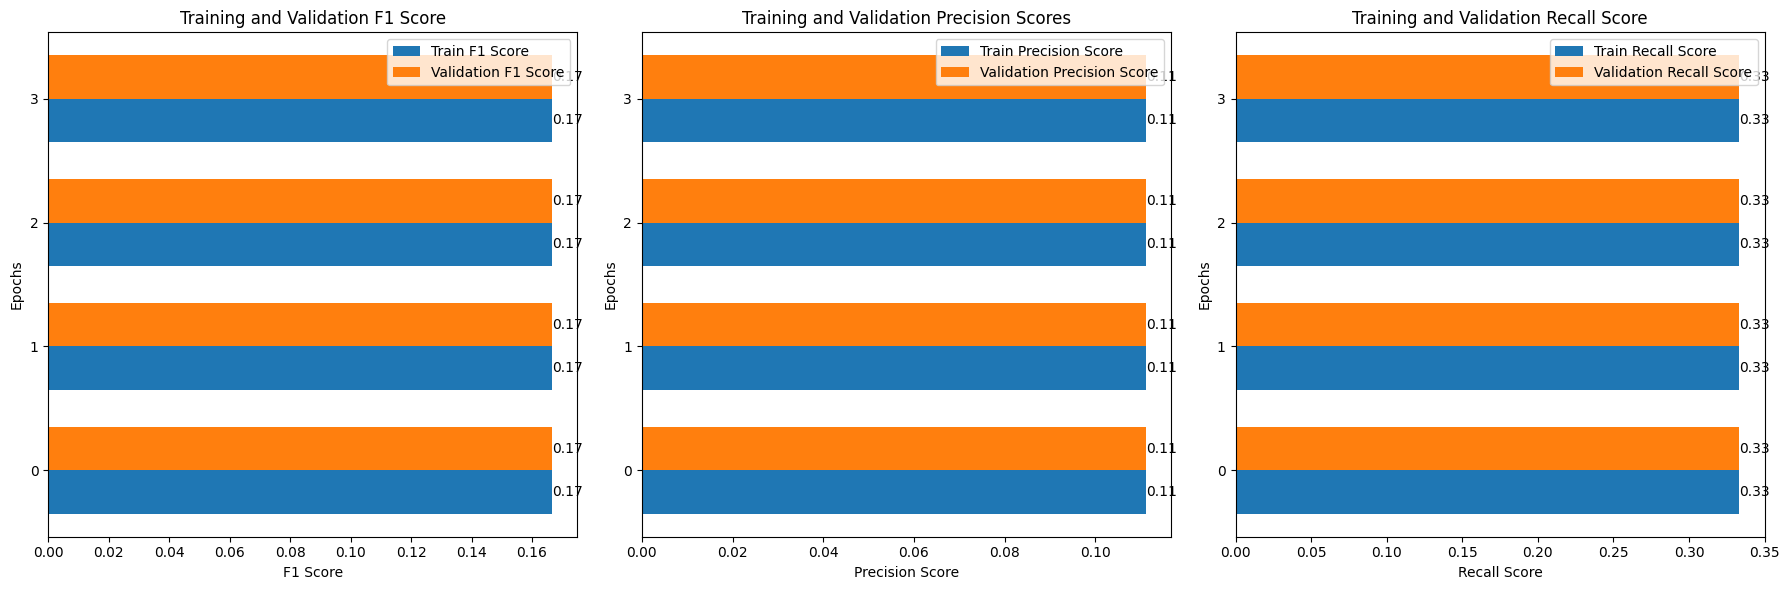


------ LEARNING RATE = 0.01 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Rec

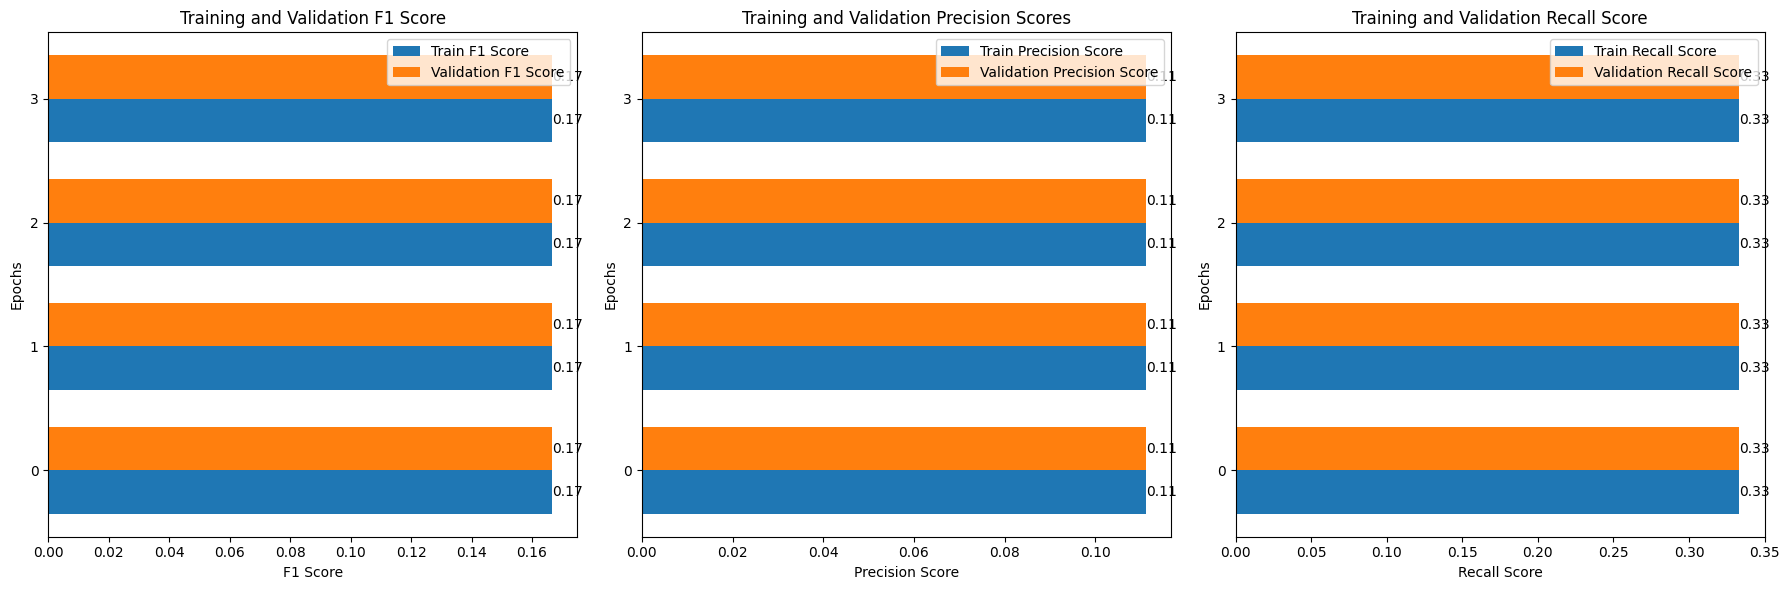


------ LEARNING RATE = 0.001 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Re

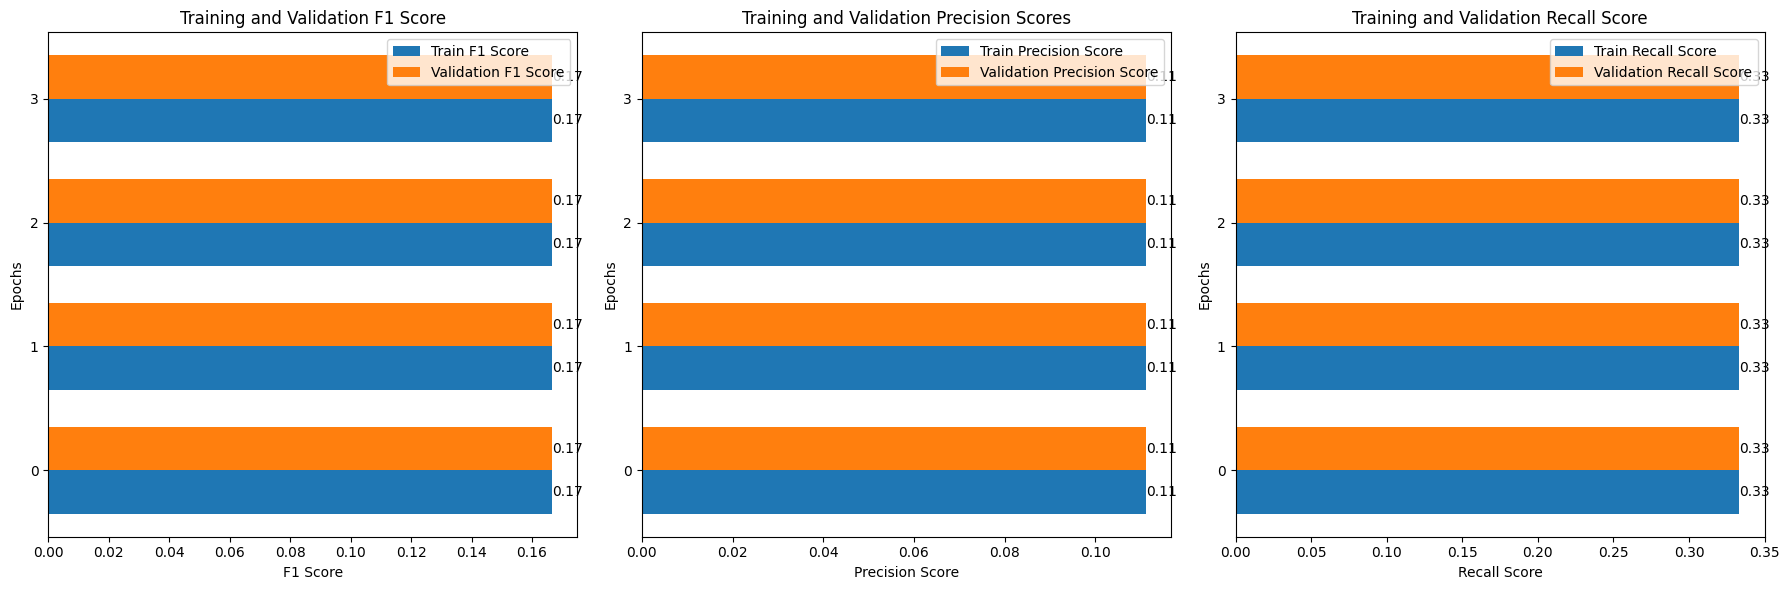

In [ ]:
epochs = 4
for lr in [0.1, 0.01, 0.001]:
    model_greekbert.to(device)
    optimizer = AdamW(model_greekbert.parameters(), lr=lr)

    print(f'\n------ LEARNING RATE = {lr} ------\n')
    model, train_acc, val_acc, train_f1, valid_f1, train_precision, valid_precision, train_recall, valid_recall = train(epochs, model_greekbert, train_dataloader, valid_dataloader, optimizer, device)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs)

<h1>Optimizer experiments</h1>

In [ ]:
optimal_lr = 0.01

optimizers_dict = {
    "AdamW": lambda params: AdamW(params, lr=optimal_lr),
    "SGD": lambda params: SGD(params, lr=optimal_lr, momentum=0.9),
    "Adam": lambda params: Adam(params, lr=optimal_lr),
}

In [ ]:
epochs = 4
for opt_name, opt_func in optimizers_dict.items():
    model_greekbert.to(device)
    optimizer = opt_func(model_greekbert.parameters())

    print(f'\n------ OPTIMIZER = {opt_name} ------\n')
    model, train_acc, val_acc, train_f1, valid_f1, train_precision, valid_precision, train_recall, valid_recall = train(epochs, model_greekbert, train_dataloader, valid_dataloader, optimizer, device)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs)


------ OPTIMIZER = AdamW ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------


KeyboardInterrupt: 

<h1>Batch size experiments</h1>


------ Batch size = 32 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 

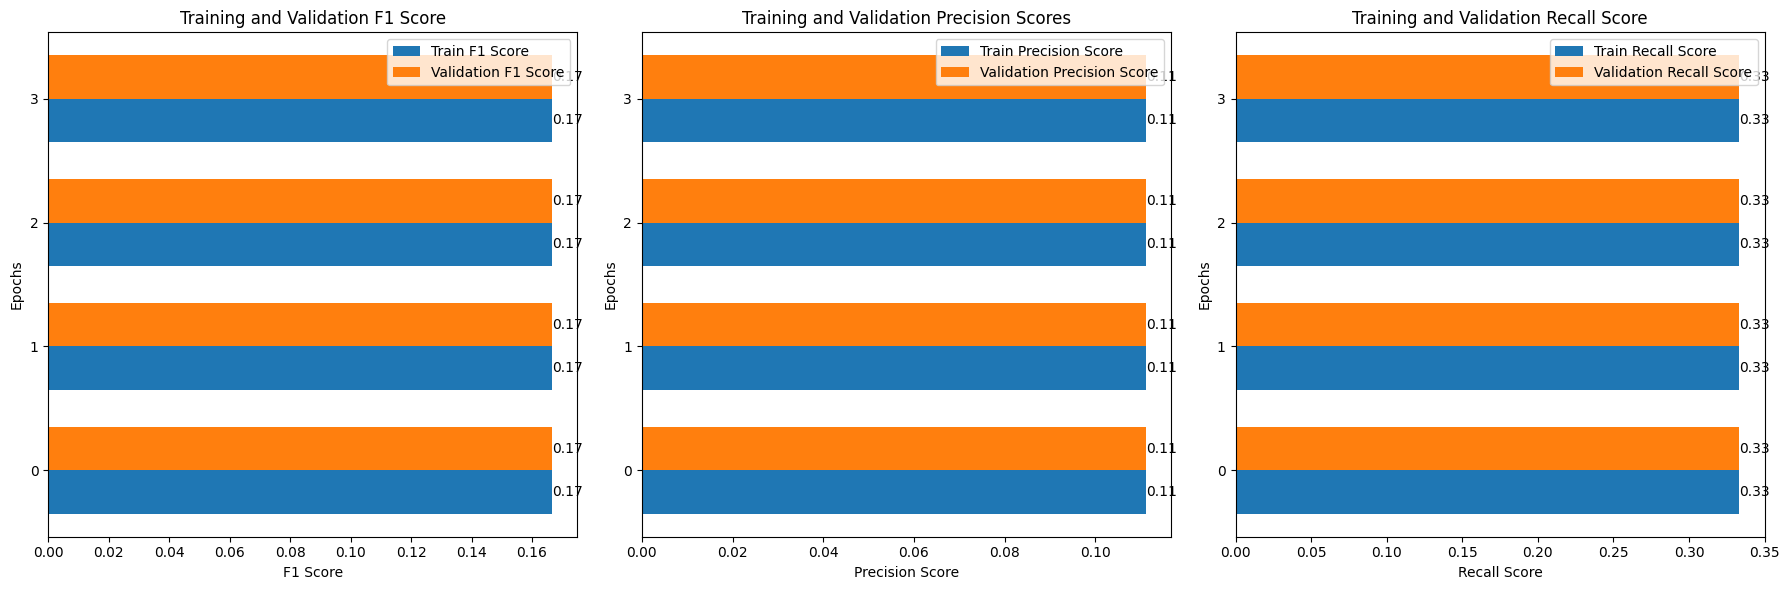


------ Batch size = 64 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 

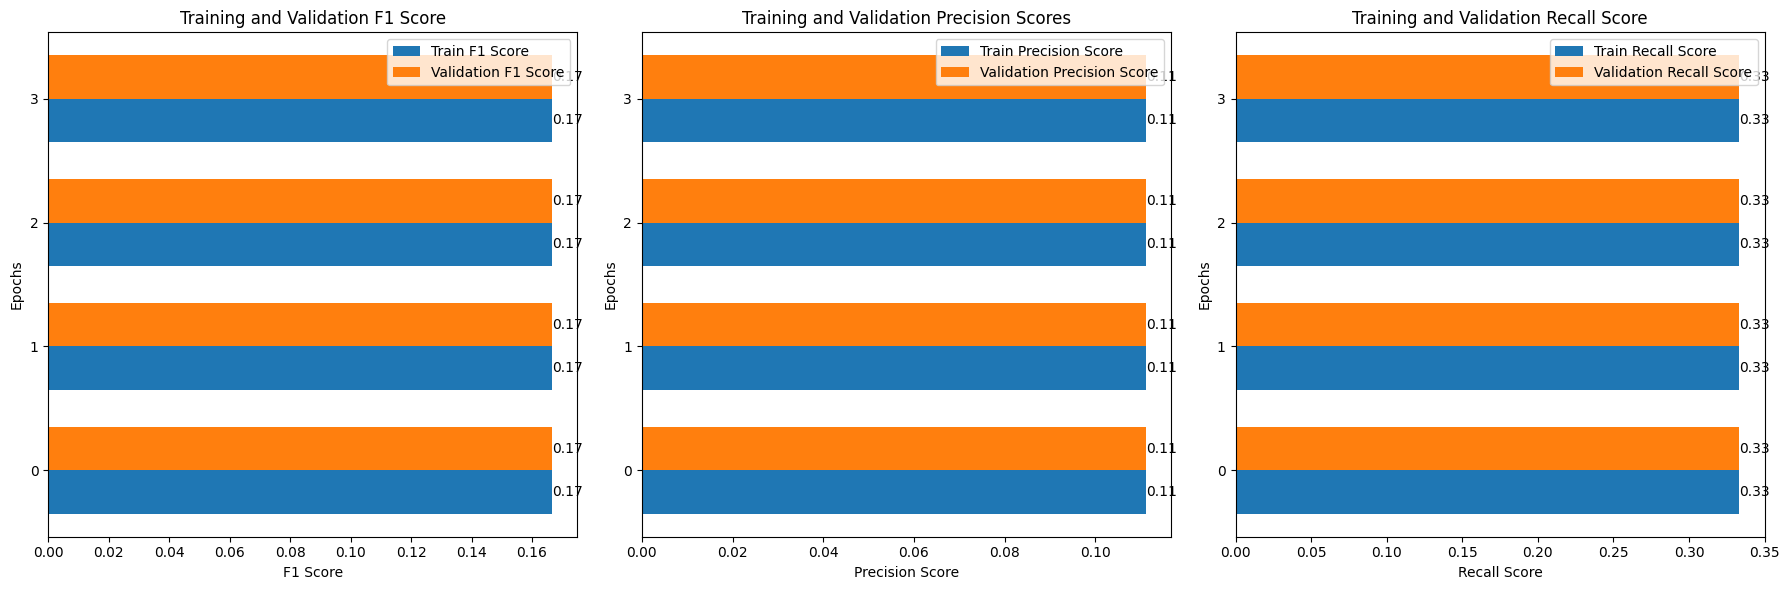


------ Batch size = 128 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall:

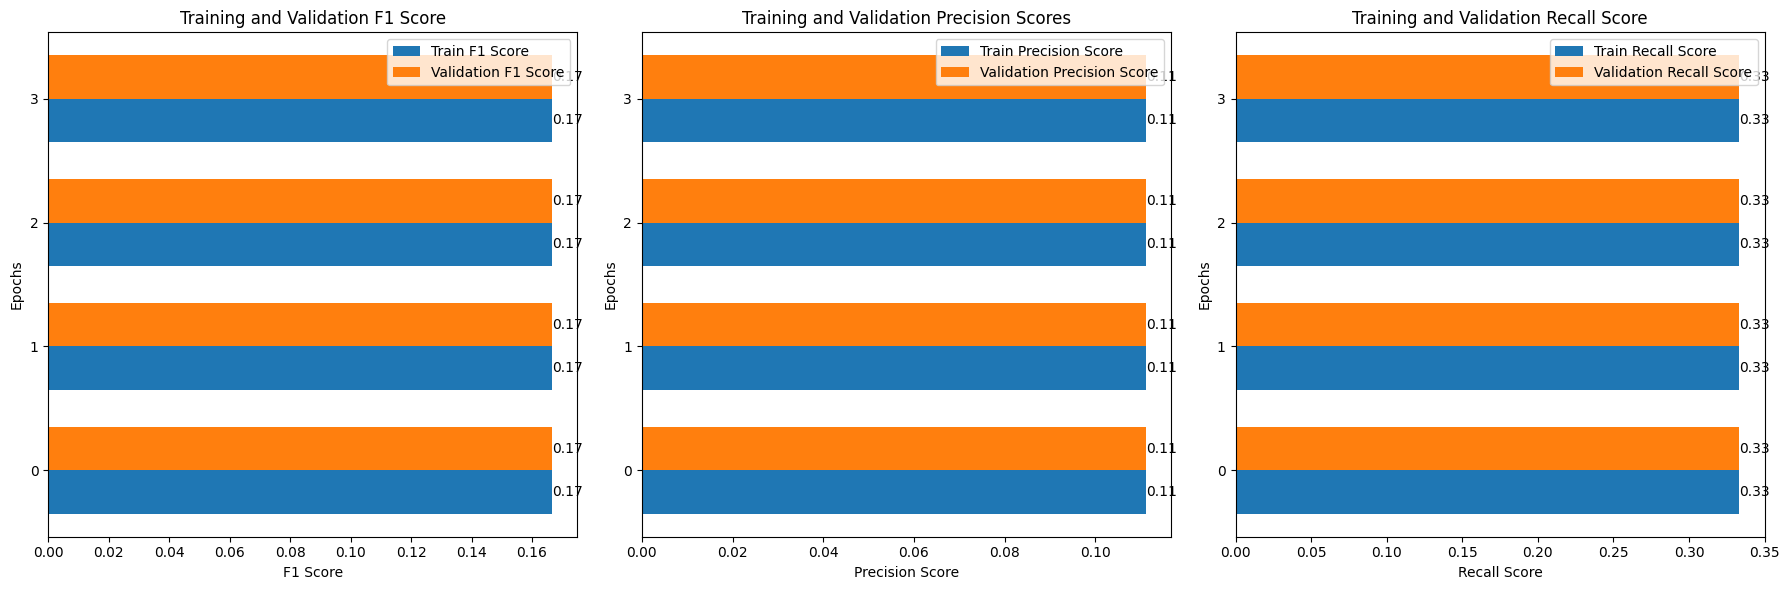


------ Batch size = 256 ------

Epoch 1/4
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 91.06 MiB is free. Process 28584 has 14.66 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 93.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:

epochs = 4
for batch in [32, 64, 128, 256]:
    model_greekbert.to(device)
    optimizer = AdamW(model_greekbert.parameters(), lr=0.01)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch)
    print(f'\n------ Batch size = {batch} ------\n')
    model, train_acc, val_acc, train_f1, valid_f1, train_precision, valid_precision, train_recall, valid_recall = train(epochs, model_greekbert, train_dataloader, valid_dataloader, optimizer, device)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs)

<h1>DistilGREEK-BERT</h1>


In [ ]:
# Dataframes -> GreekEleactionsDataset instances
train_dataset = GreekElectionsDataset(df_train_set['Text'], df_train_set['Sentiment'], tokenizer_distilgreekbert, max_token_len=128)
valid_dataset = GreekElectionsDataset(df_valid_set['Text'], df_valid_set['Sentiment'], tokenizer_distilgreekbert, max_token_len=128)
test_dataset = GreekElectionsDataset(df_test_set['Text'], tokenizer_distilgreekbert, max_token_len=128)

batch_size = 32


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

<h1>Learning rate experiments</h1>


------ LEARNING RATE = 0.1 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Reca

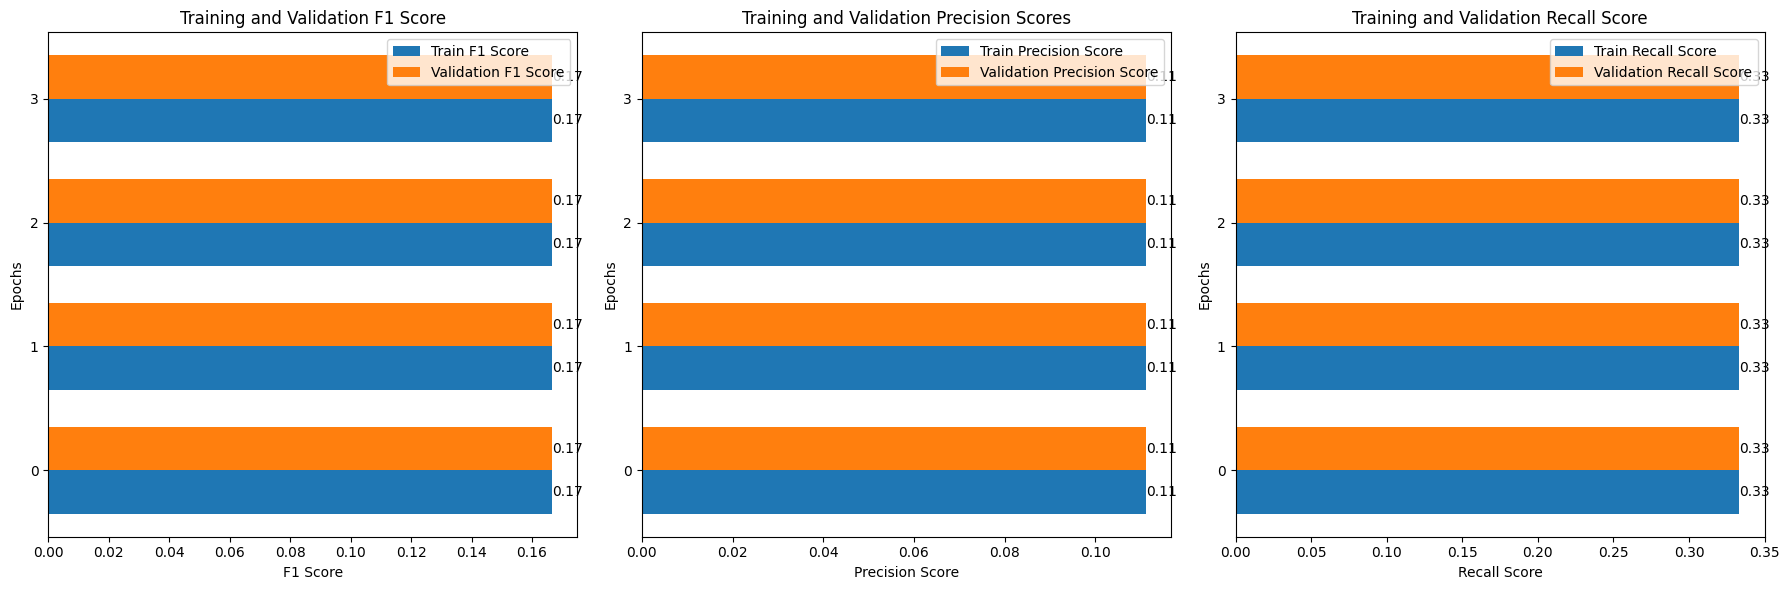


------ LEARNING RATE = 0.01 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Rec

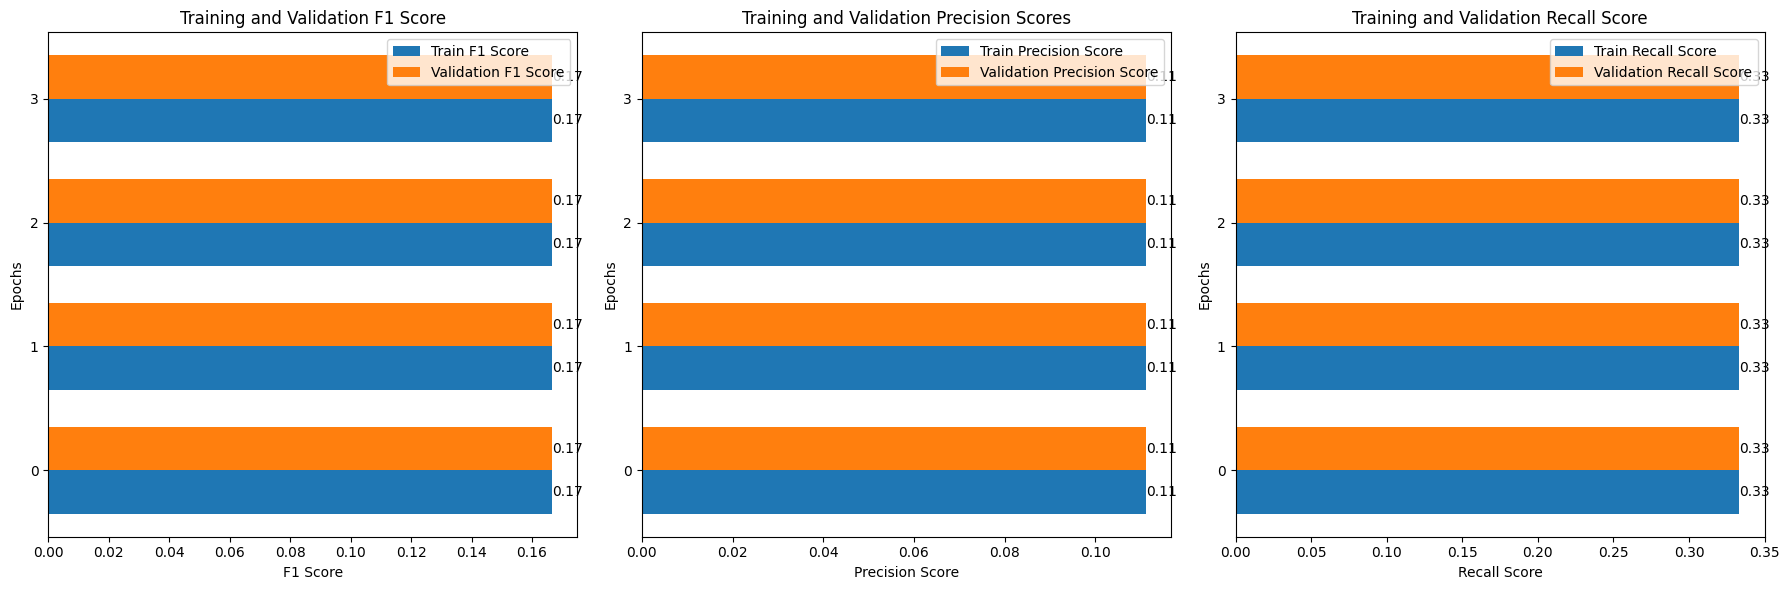


------ LEARNING RATE = 0.001 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Re

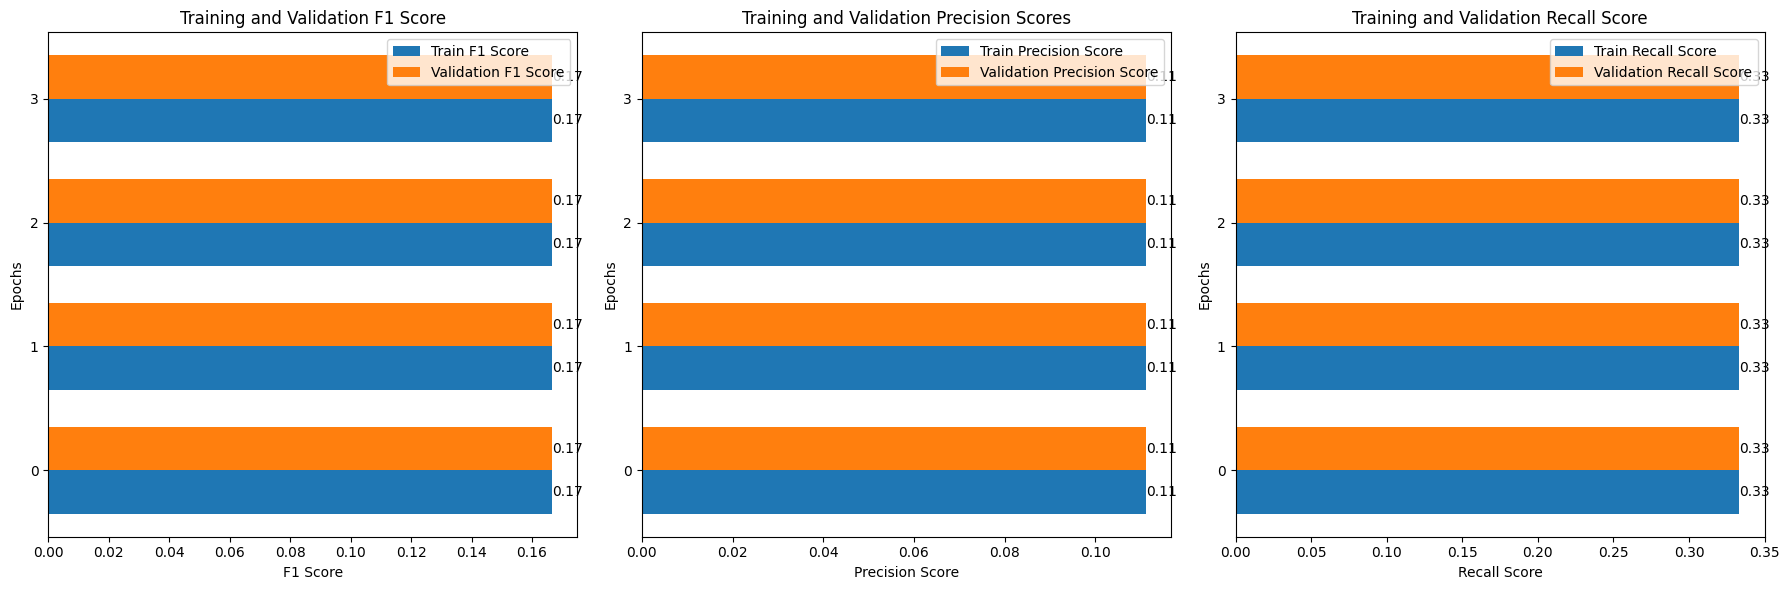

In [ ]:
epochs = 4

for lr in [0.1, 0.01, 0.001]:
    optimizer = AdamW(model_distilgreekbert.parameters(), lr=lr)
    model_distilgreekbert.to(device)
    print(f'\n------ LEARNING RATE = {lr} ------\n')
    model, train_acc, val_acc, train_f1, valid_f1, train_precision, valid_precision, train_recall, valid_recall = train(epochs, model_distilgreekbert, train_dataloader, valid_dataloader, optimizer, device)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs)

<h1>Optimizer experiments</h1>

In [ ]:
optimal_lr = 0.01

optimizers_dict = {
    "AdamW": lambda params: AdamW(params, lr=optimal_lr),
    "SGD": lambda params: SGD(params, lr=optimal_lr, momentum=0.9),
    "Adam": lambda params: Adam(params, lr=optimal_lr),
}


------ OPTIMIZER = AdamW ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall

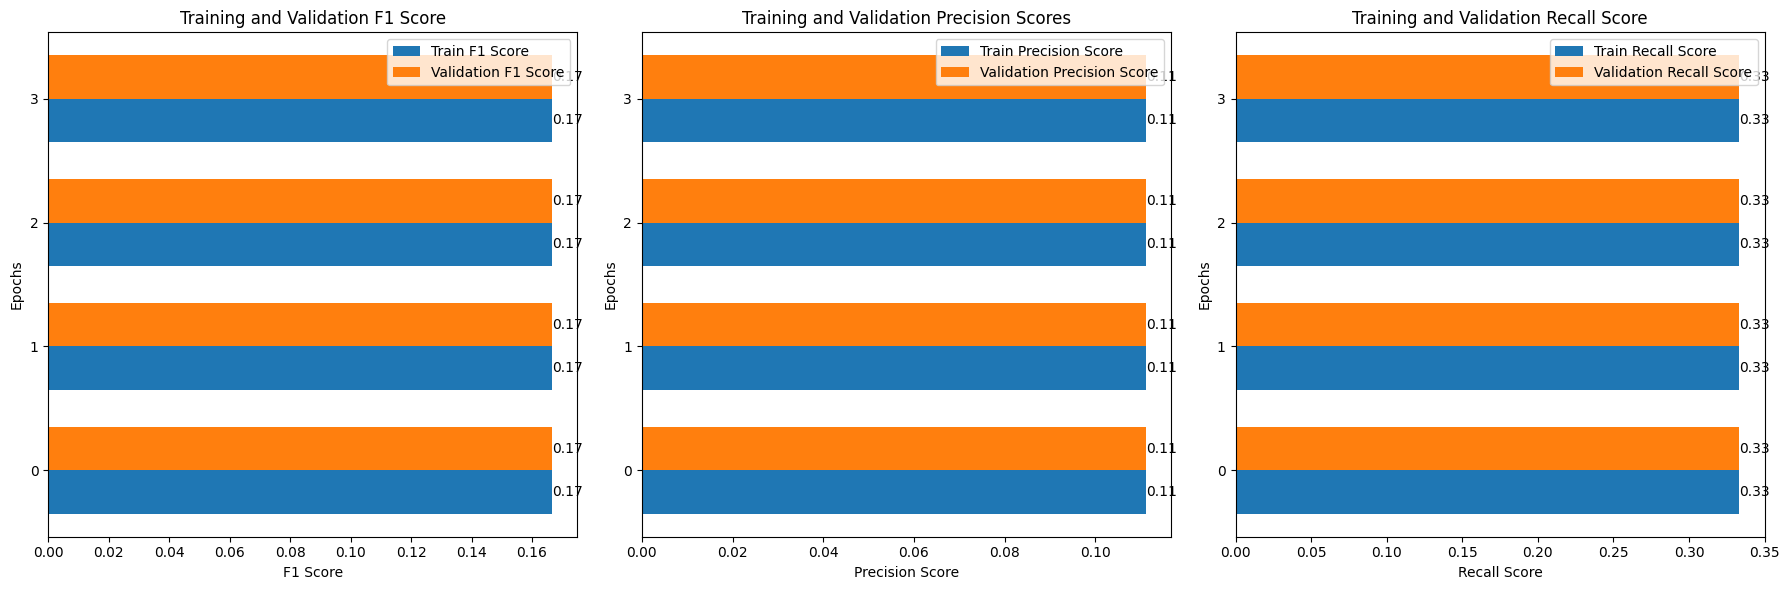


------ OPTIMIZER = SGD ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 

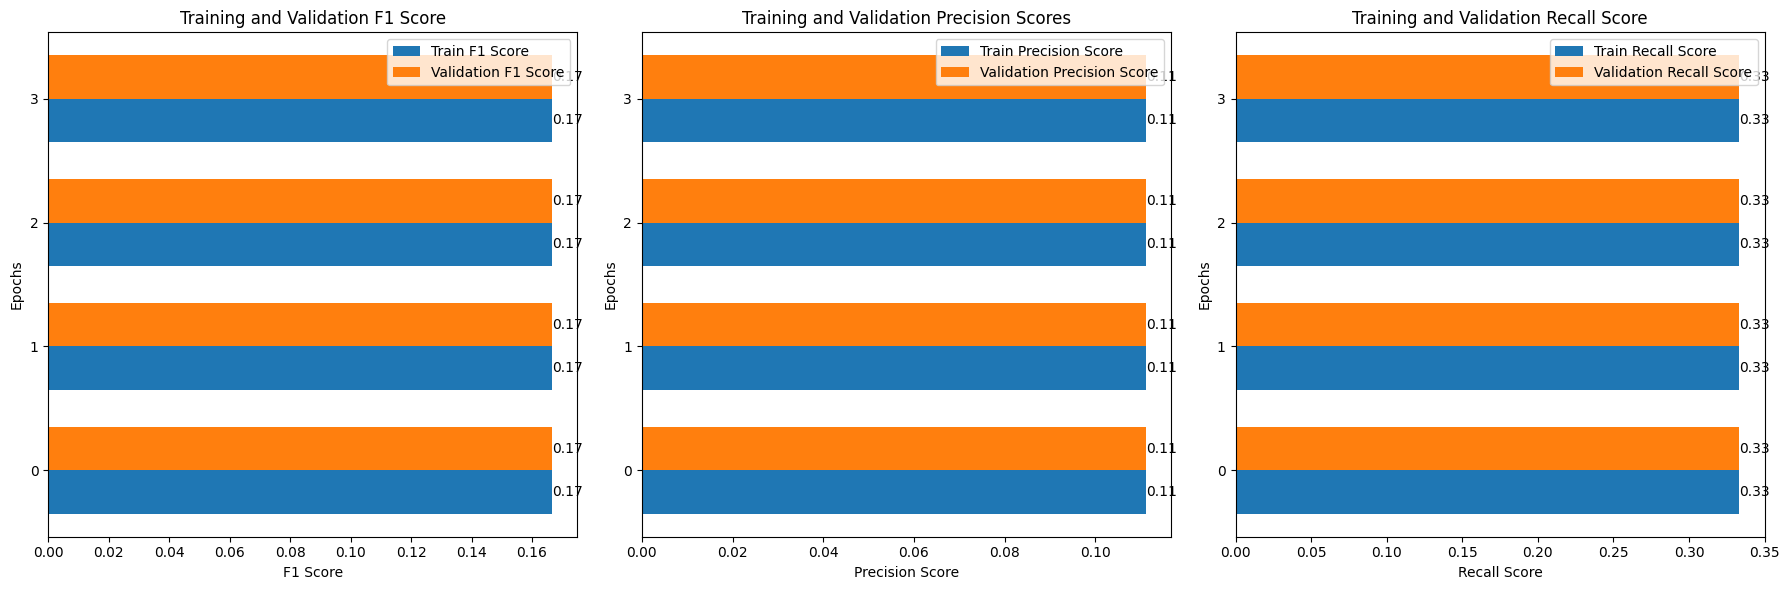


------ OPTIMIZER = Adam ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall:

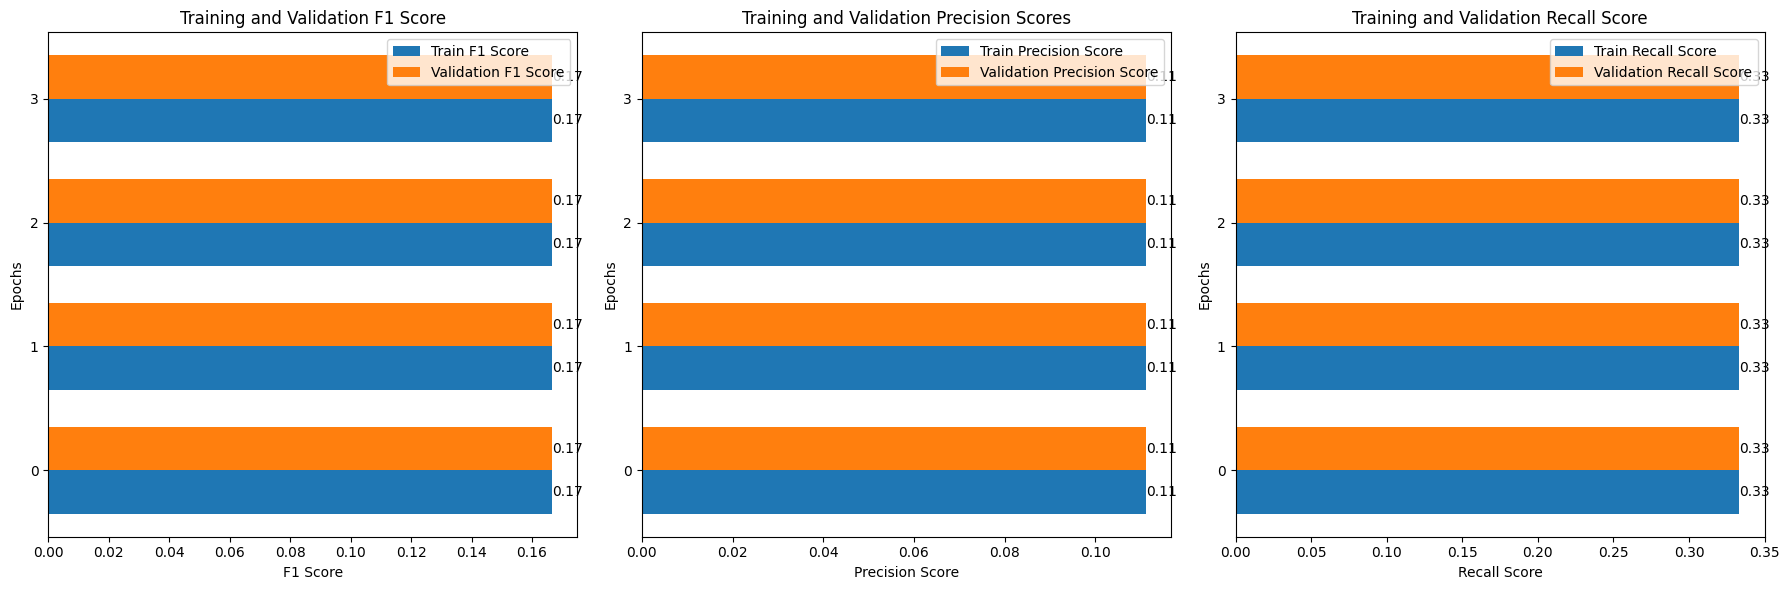

In [ ]:
epochs = 4
for opt_name, opt_func in optimizers_dict.items():
    model_distilgreekbert.to(device)
    optimizer = opt_func(model_distilgreekbert.parameters())

    print(f'\n------ OPTIMIZER = {opt_name} ------\n')
    model, train_acc, val_acc, train_f1, valid_f1, train_precision, valid_precision, train_recall, valid_recall = train(epochs, model_distilgreekbert, train_dataloader, valid_dataloader, optimizer, device)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs)

<h1>Batch size experiments</h1>


------ Batch size = 32 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 

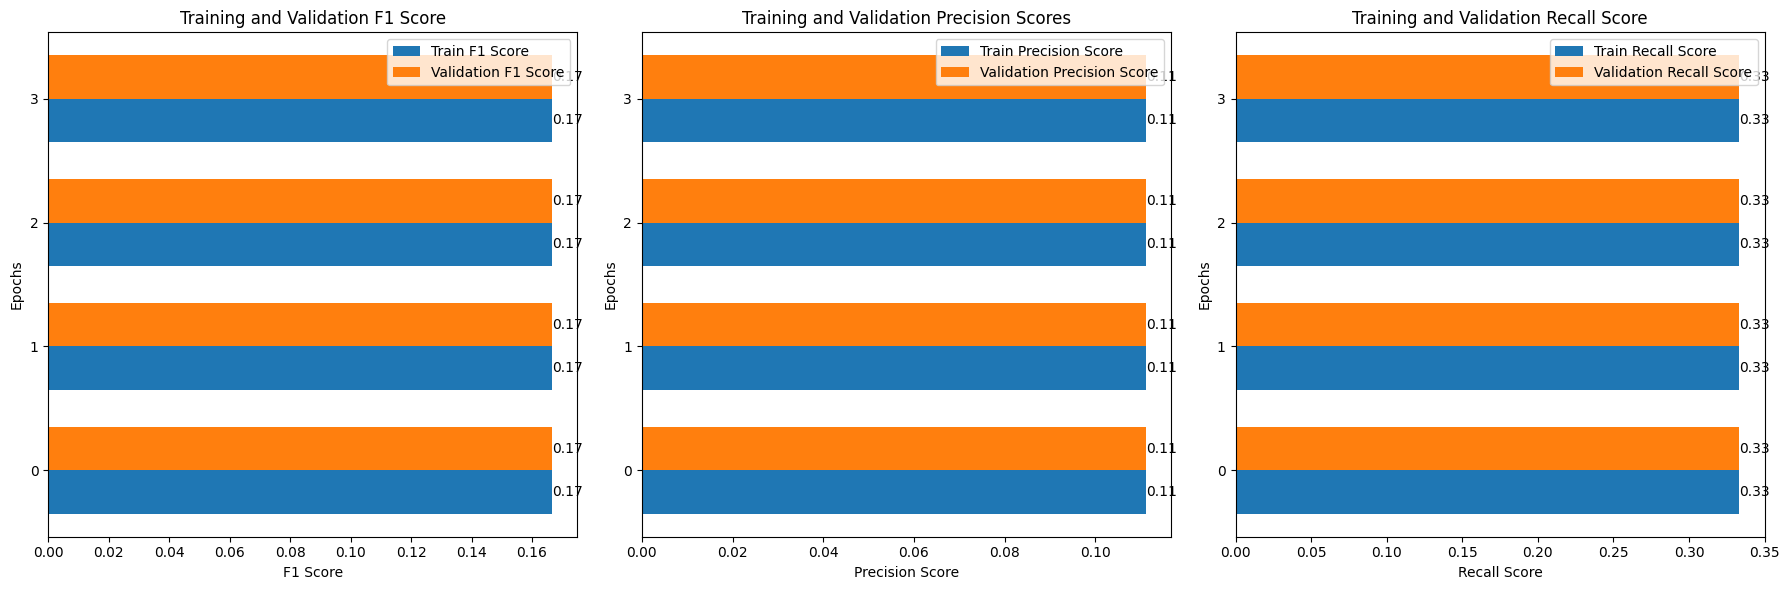


------ Batch size = 64 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 

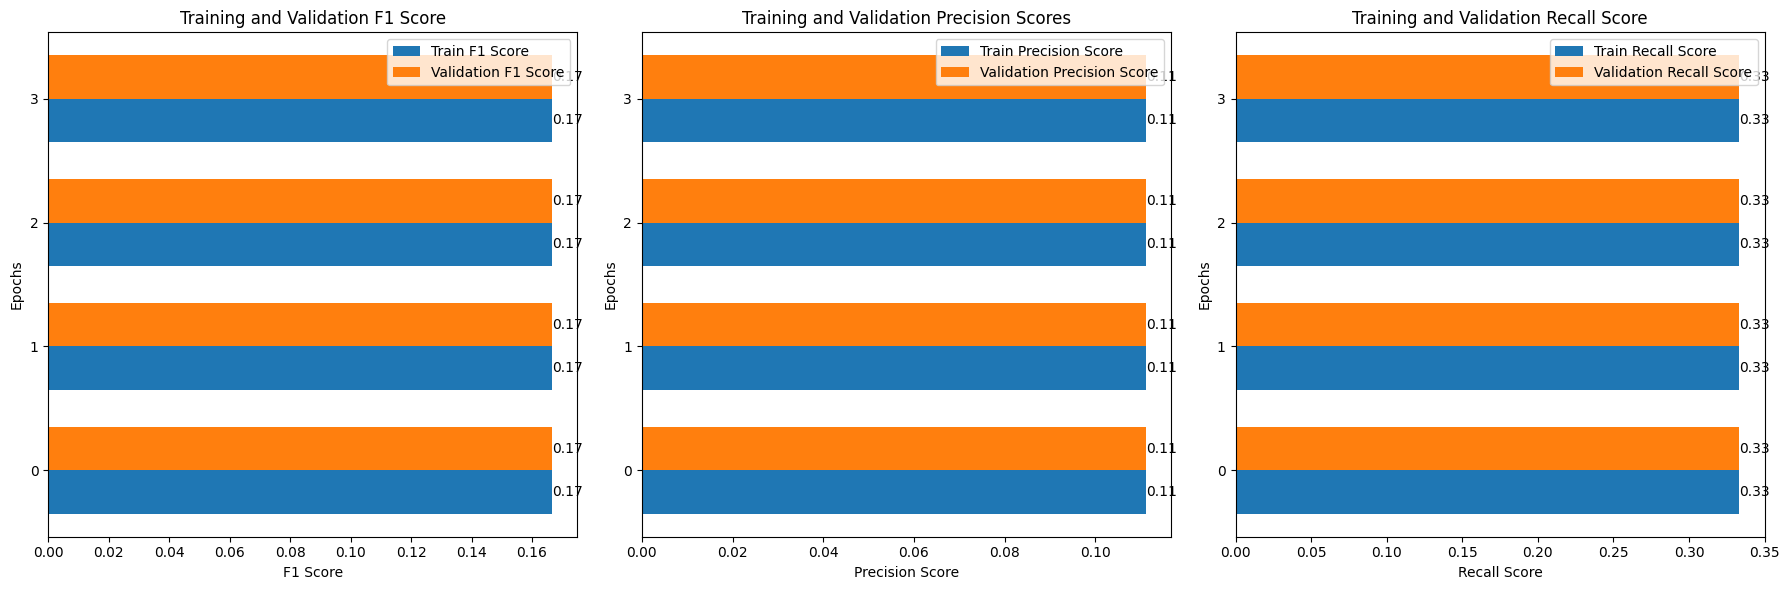


------ Batch size = 128 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall:

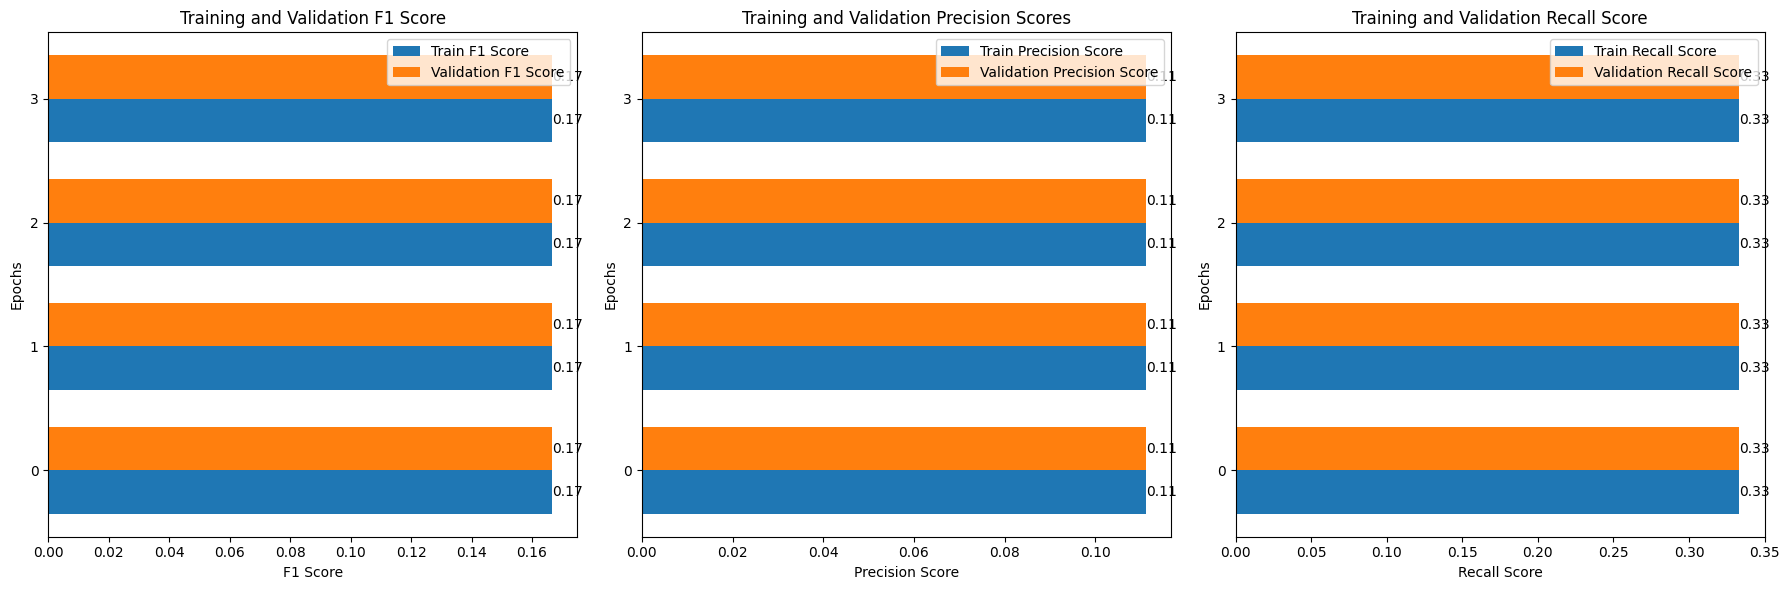


------ Batch size = 256 ------

Epoch 1/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666]
Epoch 2/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666]
Epoch 3/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
Epoch 4/4
----------
Train accuracy 0.3333333333333333 Validation accuracy 0.3333333333333333
Train F1: 0.17, Valid F1: 0.17, Train Precision: 0.11, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall:

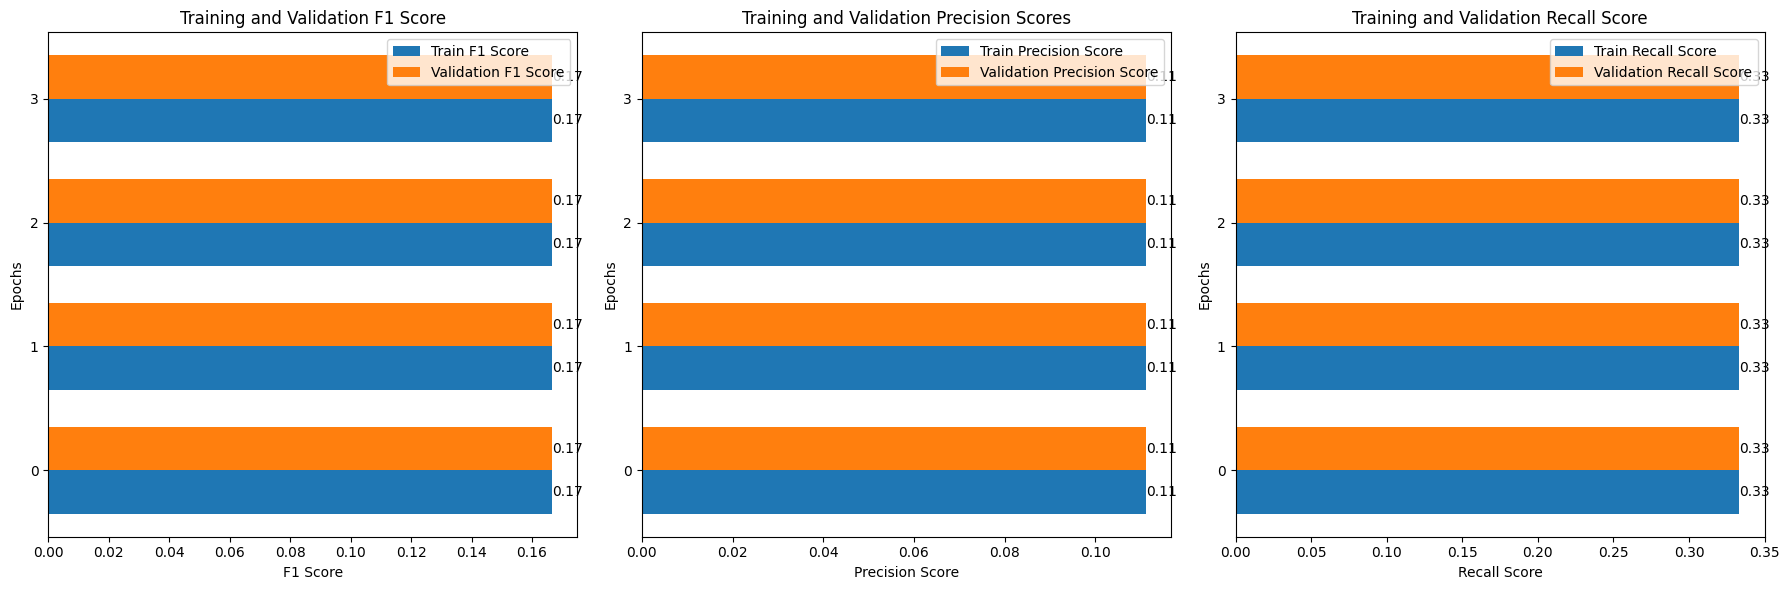

In [ ]:
epochs = 4
for batch in [32, 64, 128, 256]:
    model_distilgreekbert.to(device)
    optimizer = AdamW(model_distilgreekbert.parameters(), lr=0.01)
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch)
    print(f'\n------ Batch size = {batch} ------\n')
    model, train_acc, val_acc, train_f1, valid_f1, train_precision, valid_precision, train_recall, valid_recall = train(epochs, model_distilgreekbert, train_dataloader, valid_dataloader, optimizer, device)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision, epochs)